### 研究目标：根据医生临床诊断糖尿病一些经验指标，结合机器学习算法构建糖尿病预测模型，期待未来可以辅助临床医生或者个人完成糖尿病的评估。
### 数据样本：数据来源于UCL机器学习数据库，样本总量为768例，其中8个特征变量，一个标签（是否患有糖尿病）；
+ Pregnancies:怀孕次数
+ Glucose:葡萄糖测试值
+ BloodPressure:血压
+ SkinThickness:皮脂厚度
+ BMI:身体质量指数
+ DiabetesPedigreeFunction:糖尿病遗传函数
+ Age:年龄
+ Insulin:胰岛素
+ 0utcome:糖尿病标签
```
为了更好的理解逻辑回归、矩阵运算、我这里引用了之前本地获取到的数据样本，来理解回归过程。diabetes.xlsx 文件已提交同目录下。
```

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

In [5]:
# 加载数据，查看数据是否读取成功
# diabetes_data = pd.read_excel('F:\hyt\AI算法视频\第二周_pytorch逻辑回归\作业\diabetes.xlsx')
diabetes_data = pd.read_excel('./diabetes.xlsx')
# print('数据矩阵    ',diabetes_data.shape)
# print('查看标签分布',diabetes_data.Outcome.value_counts())
# diabetes_data.Outcome.value_counts().plot(kind='bar')

In [6]:

# 1. 读出的数据类型为 dataframe 类型，需要转换为矩阵类型
def dataframe_2_array(data):
    datasets = []
    for i in range(len(data)):
        datasets.append(data.iloc[i])
        # i+=1
    return datasets

# 2. 目前样例数据数据类型不统一，书写方法，使其全部转为浮点数据类型
def str_2_float_converter(dataset):
    # dataset=dataset[1:]
    for i in range(len(dataset[0])):
        for row in dataset:
            row[i]=float(row[i])

# 3.获取指定矩阵列当中最大数值和最小数值
def fetch_min_max_from_array(dataset):
    min_max_list=[]
    for i in range(len(dataset[0])): # 遍历 列元素
        col_value=[row[i] for row in dataset]
        min_value=min(col_value)
        max_value=max(col_value)
        min_max_list.append([min_value,max_value])
    return min_max_list
        
# 4.数据标准化
def fetch_value_normalization(dataset):
    min_max_list = fetch_min_max_from_array(dataset)
    for i in range(len(dataset[0])):# 遍历所有的列
        min_value = min_max_list[i][0]# 获取最小值
        max_value = min_max_list[i][1]# 获取最大值
        for row in dataset:
            row[i] = (row[i]-min_value)/(max_value-min_value)

In [ ]:
# 1.调用方法，转换 dataframe 为 数组类型
dataset = dataframe_2_array(diabetes_data)
# 2.调用方法，转换 数组内部所有数值 为 浮点类型
str_2_float_converter(dataset)
# 3.数据标准化
fetch_value_normalization(dataset)

# 特征工程
x = np.delete(dataset, -1, axis=1)
y = [row[len(dataset[0])-1] for row in dataset]


In [8]:
model = ExtraTreesClassifier()
model.fit(x, y)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.10842352 0.23568234 0.10106799 0.08024634 0.07402309 0.1367802
 0.11830973 0.14546678]


In [7]:
# 预测数据的基础模型
def prediction(row,coefficient):
    z = coefficient[0]
    for i in range(len(row)):
        z += coefficient[i] * row[i]
    y_hat = 1/(1+exp(-z))
    return y_hat

# 预估系数
def estimate_coefficient(x_train,y_train,iflog,learn_rate,epochs):
    # 初始化系数列表
    coefficient = [0.0 for i in range(len(x_train[0]))]
    # 训练次数
    for epoch in range(epochs):
        sum_error = 0
        for i in range(len(x_train)):
            row = x_train[i]
            y_value = y_train[i]
            y_hat = prediction(row,coefficient)
            error = y_hat - y_value
            sum_error += error**2
            coefficient[0] = coefficient[0] - learn_rate* error * y_hat * (1.0- y_hat)
            for i in range(len(row)):
                coefficient[i] =  coefficient[i] - learn_rate* error * y_hat * (1- y_hat) *row[i]
        if iflog == True:
            print('This is epoch < %s >, sum_error is <%.4f>' %(epoch,sum_error))
    return coefficient


# 逻辑回归函数，对测试数据进行预测
def logistic_regression(x_train,y_train,x_test,iflog,learn_rate,epochs):
    predict_result = []
    coefficient= estimate_coefficient(x_train,y_train,iflog,learn_rate,epochs)
    for row in x_test:
        y_hat = round(prediction(row,coefficient))
        predict_result.append(y_hat)
    return predict_result

# 计算模型的准确性,返回正确预测的个数
def fetch_accuracy(y_test,y_predict):
    correct_num=0
    for i in range(len(y_test)):
        if y_test[i] == y_predict[i]:
            correct_num += 1
    return correct_num/float(len(y_test)) *100



In [ ]:
# 定义学习参数
learn_rate = 0.00 # 学习率
epochs = 5000 # 训练次数
iflog = False # 是否打出每一次的训练日志
test_number = 0.3 # 切分数据集的大小

learn_rate_inits = []
accuracy_inits = []
print('开始学习过程：')
while learn_rate < 1.00:
    # 切分数据集，保持训练集和测试集中的数据类型的比例和切分前一直，分层随机抽样
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_number,stratify=y,random_state=20)
    # 逻辑回归预测
    y_predict = logistic_regression(x_train,y_train,x_test,iflog,learn_rate,epochs)
    # 计算准确率
    accuracy = fetch_accuracy(y_test,y_predict)
    
    print('本次学习过程中，数据切分大小= %s , 学习率 = %s ，训练次数= %s ，模型准确率= %s'%(test_number,learn_rate,epochs,accuracy))
    
    learn_rate_inits.append(learn_rate)
    accuracy_inits.append(accuracy)

    learn_rate += 0.02
print('学习循环结束！')





开始学习过程：
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.0 ，训练次数= 5000 ，模型准确率= 64.93506493506493
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.01 ，训练次数= 5000 ，模型准确率= 74.02597402597402
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.02 ，训练次数= 5000 ，模型准确率= 73.59307359307358
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.03 ，训练次数= 5000 ，模型准确率= 73.59307359307358
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.04 ，训练次数= 5000 ，模型准确率= 74.02597402597402
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.05 ，训练次数= 5000 ，模型准确率= 73.59307359307358
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.060000000000000005 ，训练次数= 5000 ，模型准确率= 72.72727272727273
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.07 ，训练次数= 5000 ，模型准确率= 72.72727272727273
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.08 ，训练次数= 5000 ，模型准确率= 72.72727272727273
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.09 ，训练次数= 5000 ，模型准确率= 73.59307359307358
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.09999999999999999 ，训练次数= 5000 ，模型准确率= 73.16017316017316
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.10999999999999999 ，训练次数= 5000 ，模型准确率= 72.72727272727273
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.11999999999999998 ，训练次数= 5000 ，模型准确率= 72.72727272727273
本次学习过程中，数

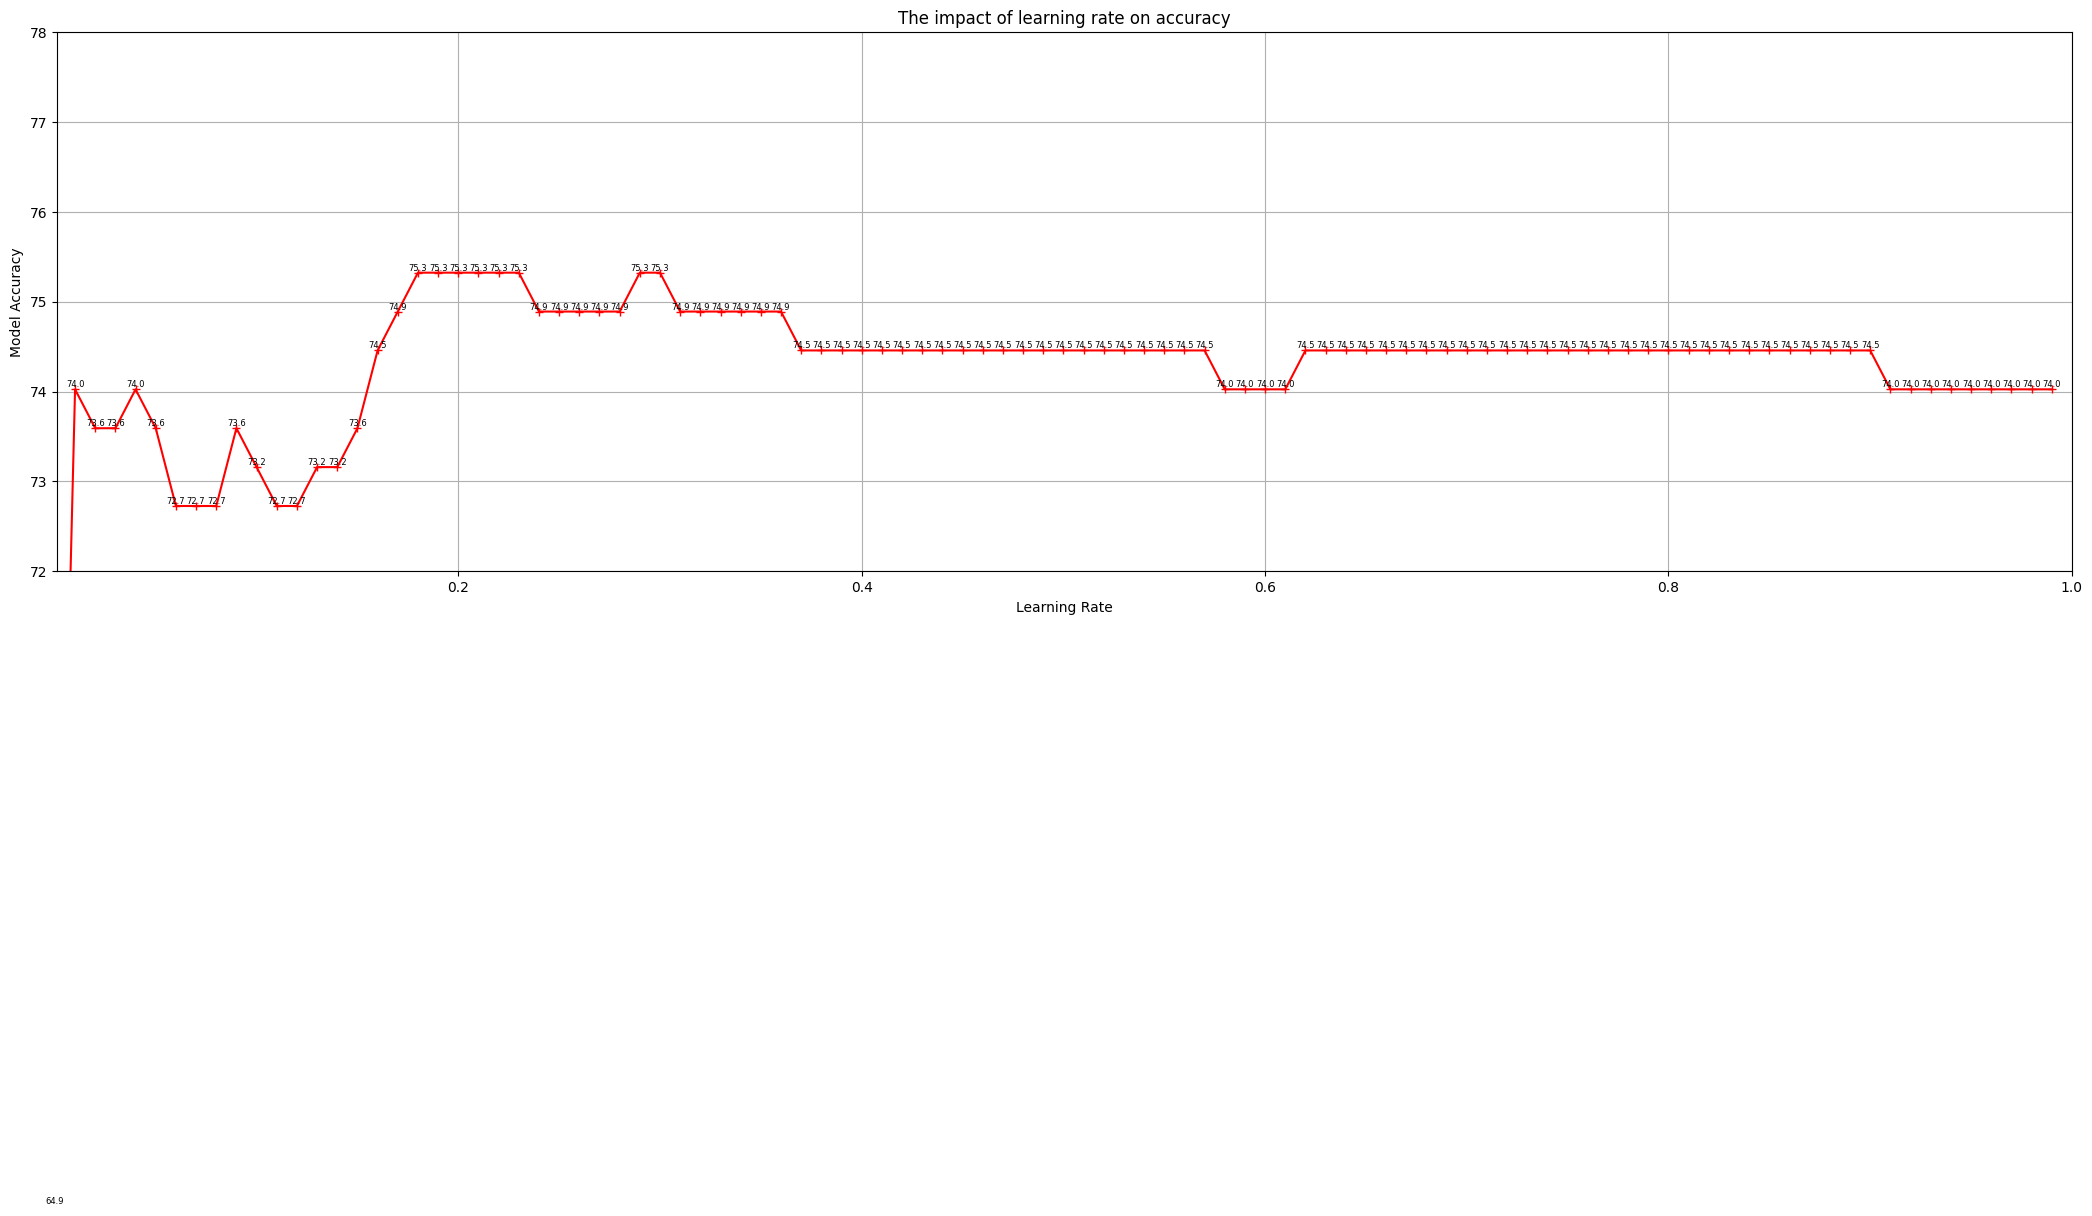

In [31]:
# print(learn_rate_inits)
# print(accuracy_inits)
plt.figure(figsize=(26,7))
plt.grid(True)
plt.xlim(0.001, 1)
plt.ylim(72, 78)
plt.title("The impact of learning rate on accuracy")
plt.ylabel('Model Accuracy')
plt.xlabel('Learning Rate')
plt.plot(learn_rate_inits, accuracy_inits, label="learn_rate", color="red", marker = "+",linestyle="-")
for a,b in zip(learn_rate_inits,accuracy_inits):
    plt.text(a,b,round(b,1),ha='center',va='bottom',fontsize=6)
plt.savefig('plt_learn_rate_influence.png')
plt.show()






In [ ]:
# 定义学习参数
learn_rate = 0.20 # 学习率
epochs = 1000 # 训练次数
iflog = False # 是否打出每一次的训练日志
test_number = 0.3 # 切分数据集的大小

epochs_inits = []
accuracy_inits2 = []
print('开始学习过程：')
while epochs < 10000:
    # 切分数据集，保持训练集和测试集中的数据类型的比例和切分前一直，分层随机抽样
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_number,stratify=y,random_state=20)
    # 逻辑回归预测
    y_predict = logistic_regression(x_train,y_train,x_test,iflog,learn_rate,epochs)
    # 计算准确率
    accuracy = fetch_accuracy(y_test,y_predict)
    
    print('本次学习过程中，数据切分大小= %s , 学习率 = %s ，训练次数= %s ，模型准确率= %s'%(test_number,learn_rate,epochs,accuracy))
    
    epochs_inits.append(epochs)
    accuracy_inits2.append(accuracy)

    epochs += 500
print('学习循环结束！')



开始学习过程：
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 1000 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 1500 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 2000 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 2500 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 3000 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 3500 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 4000 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 4500 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 5000 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 5500 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 6000 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 6500 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 7000 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分大小= 0.3 , 学习率 = 0.2 ，训练次数= 7500 ，模型准确率= 75.32467532467533
本次学习过程中，数据切分

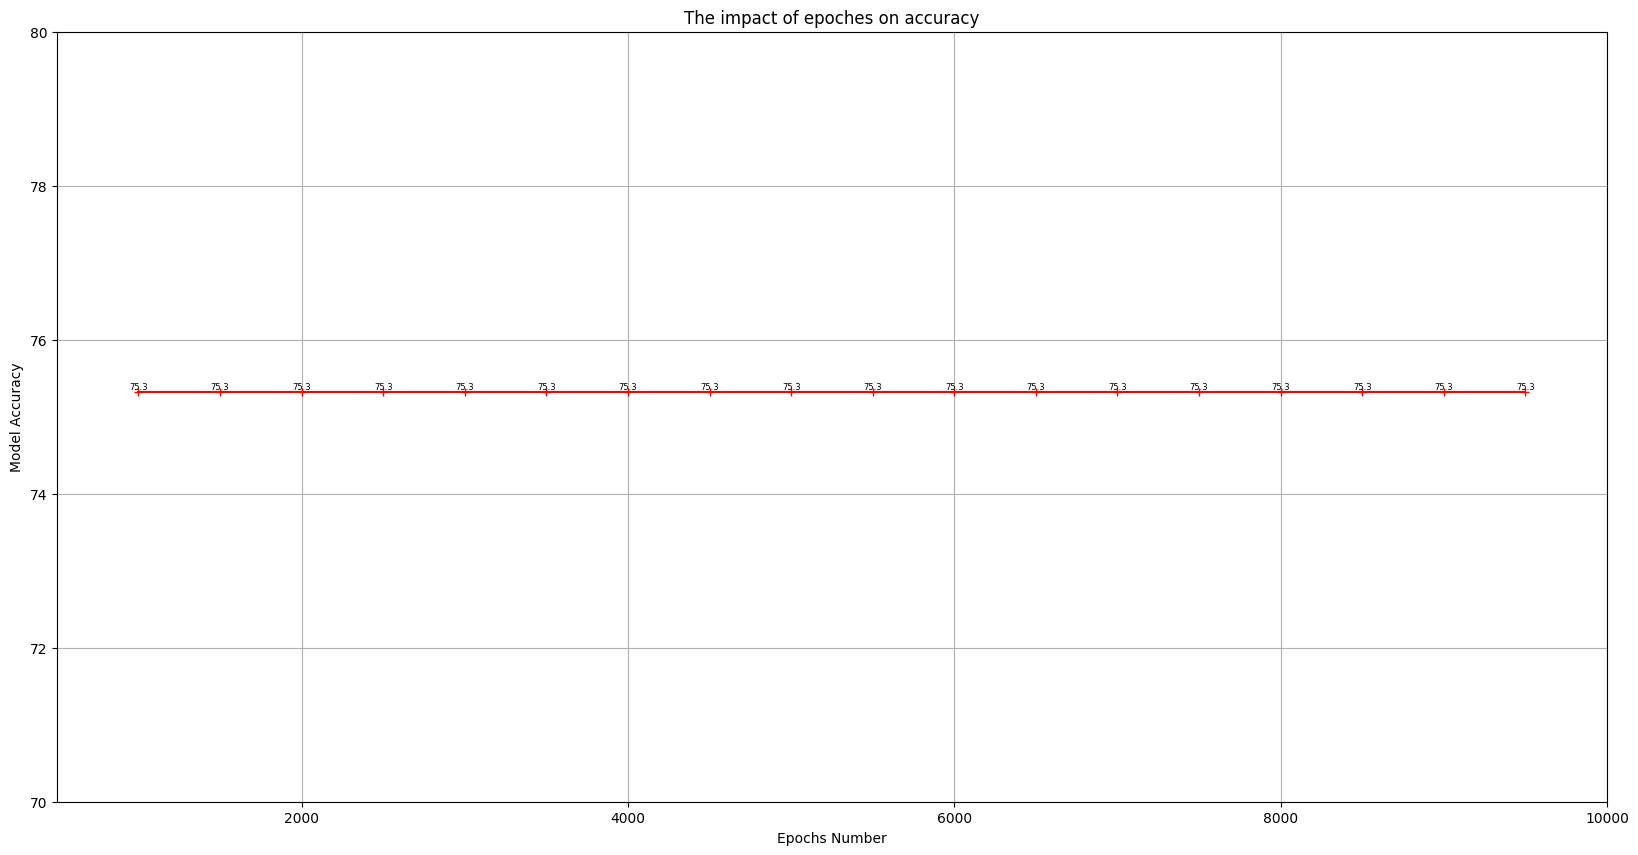

In [ ]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlim(500, 10000)
plt.ylim(70, 80)
plt.title("The impact of epoches on accuracy")
plt.ylabel('Model Accuracy')
plt.xlabel('Epochs Number')
plt.plot(epochs_inits, accuracy_inits2, label="epochs_num", color="red", marker = "+",linestyle="-")
for a,b in zip(epochs_inits,accuracy_inits2):
    plt.text(a,b,round(b,1),ha='center',va='bottom',fontsize=6)
plt.savefig('plt_epochs_influence.png')
plt.show()